In [2]:
import wandb
import pandas as pd
from loguru import logger
from tqdm import tqdm
from itertools import product
import numpy as np
from pathlib import Path
import functools
import json
from typing import Literal
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
import math

from histaug.utils import RunningStats, cached_df
from histaug.utils.display import (
    RENAME_MODELS,
    RENAME_FEATURE_EXTRACTORS,
    RENAME_TARGETS,
    TARGET_GROUPS,
    RENAME_AUGMENTATION_GROUPS,
)
from histaug.analysis.collect_results import load_aurocs

api = wandb.Api()

INDEX_COLS = ["target", "train_dataset", "test_dataset", "model", "feature_extractor", "augmentations", "seed"]

RESULTS_DIR = Path("/app/results")

# Collect results from `wandb`

In [3]:
df = df_all = load_aurocs().drop_duplicates().droplevel(["train_dataset", "test_dataset"])

df = (
    df.reset_index()
    .groupby(["target", "model", "feature_extractor", "augmentations"])
    .filter(lambda x: sorted(x.seed.values) == list(range(5)))
    .set_index(df.index.names)
    .sort_index()
)
print("Removed runs:", len(df_all) - len(df))
print(
    df_all.index.difference(df.index)
    .to_frame(index=False)
    .groupby([x for x in df.index.names if x != "seed"])
    .seed.count()
)

Removed runs: 0
Series([], Name: seed, dtype: int64)


In [94]:
def compute_overall_average(df):
    # Computer overall mean and std (across targets)
    targets = df.columns.get_level_values("target").unique()
    assert "average" not in targets
    n_targets = len(targets)
    overall_mean = df.stack().query("stats == 'mean'").droplevel("stats").sum(axis="columns").divide(n_targets)
    overall_std = (
        df.stack().query("stats == 'std'").droplevel("stats").pow(2).sum(axis="columns").pow(0.5).divide(n_targets)
    )
    df["average", "mean"] = overall_mean
    df["average", "std"] = overall_std
    return df


def results_to_latex(r, goal="min"):
    # Format for appearance
    r = r.unstack(["model", "augmentations"])
    means = r.stack("stats").query("stats == 'mean'").droplevel("stats")
    stds = r.stack("stats").query("stats == 'std'").droplevel("stats")

    has_average = "average" in means.columns

    formatted = means.map(lambda x: f"{x:.2f}") + " \\pm " + stds.map(lambda x: f"{x:.2f}")

    # Make best model bold
    best_mask = means == getattr(means, goal)(axis="index")
    formatted[best_mask] = "\\mathbf{" + formatted[best_mask] + "}"
    formatted = "$" + formatted + "$"
    formatted = formatted.stack("model")
    formatted = formatted.swaplevel("feature_extractor", "model").sort_index()

    formatted = formatted.stack(["augmentations"])

    # Set index order to augmentations, model, feature_extractor
    formatted = formatted.reorder_levels(["augmentations", "model", "feature_extractor"]).reindex(
        [*RENAME_TARGETS.keys(), *(["average"] if has_average else [])], axis=1
    )

    def sort_df_index(df, keys):
        """Sort a dataframe by index level values.

        Args:
            df: Dataframe to sort.
            keys: dict of {level: order} where:
                level: Name of index level to sort by.
                order: List of values in the order you want them to appear in that level
        """

        return df.sort_index(key=lambda x: x.map({v: i for i, v in enumerate(keys[x.name])}) if x.name in keys else x)

    def rename_df(df):
        rename_levels = {
            "feature_extractor": "Feature extractor",
            "model": "Model",
            "augmentations": "Augmentations",
            "target": "Target",
        }
        for axis in [0, 1]:
            d = df.index if axis == 0 else df.columns
            for level in d.names:
                if level == "feature_extractor":
                    df = df.rename(RENAME_FEATURE_EXTRACTORS, level=level, axis=axis)
                elif level == "model":
                    df = df.rename(RENAME_MODELS, level=level, axis=axis)
                elif level == "augmentations":
                    df = df.rename(RENAME_AUGMENTATION_GROUPS, level=level, axis=axis)
                elif level == "target":
                    df = df.rename(RENAME_TARGETS, level=level, axis=axis)

        df.index.set_names([rename_levels.get(x, x) for x in df.index.names], inplace=True)
        df.columns.set_names([rename_levels.get(x, x) for x in df.columns.names], inplace=True)
        return df

    formatted = sort_df_index(
        formatted,
        {
            "augmentations": RENAME_AUGMENTATION_GROUPS.keys(),
            "model": RENAME_MODELS.keys(),
            "feature_extractor": RENAME_FEATURE_EXTRACTORS.keys(),
        },
    )
    formatted = rename_df(formatted).rename(columns={"average": "Average"})

    col_format = (
        "lll|" + "|".join(("c" * len(group) for group in TARGET_GROUPS.values())) + ("|c" if has_average else "")
    )
    return formatted.to_latex(escape=False, column_format=col_format, multicolumn_format="c")

## Show results

In [123]:
d = df["test_auroc"].groupby(["augmentations", "model", "feature_extractor", "target"]).agg(["mean", "std"])
d.columns.name = "stats"
d = d.unstack("target").reorder_levels(["target", "stats"], axis=1).sort_index(axis=1)
# d = compute_overall_average(d)
d

target                                                BRAF            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.478191  0.101236   
                               ctranspath         0.698404  0.019090   
                               dino_p16           0.734973  0.070102   
                               owkin              0.663298  0.034364   
                               resnet50           0.588431  0.069317   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.588630  0.061571   
                               swav               0.698604  0.076306   
                               swin               0.559441  0.091344   
                               vit                0.611370  0.066482   
                               vits               0.588697  0.051542   

target                                                CDH1            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.761850  0.011911   
                               ctranspath         0.781154  0.037715   
                               dino_p16           0.792233  0.012664   
                               owkin              0.757624  0.010411   
                               resnet50           0.618675  0.038674   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.738378  0.044368   
                               swav               0.760708  0.049815   
                               swin               0.698458  0.033697   
                               vit                0.718275  0.031322   
                               vits               0.761508  0.014852   

target                                                KRAS            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.599080  0.061902   
                               ctranspath         0.610848  0.027600   
                               dino_p16           0.607095  0.040048   
                               owkin              0.621959  0.051217   
                               resnet50           0.550375  0.028858   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.536111  0.080656   
                               swav               0.558709  0.030219   
                               swin               0.605293  0.058972   
                               vit                0.544182  0.010245   
                               vits               0.553979  0.040763   

target                                                 MSI            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.569136  0.079763   
                               ctranspath         0.830247  0.062138   
                               dino_p16           0.891512  0.029279   
                               owkin              0.873354  0.034281   
                               resnet50           0.721193  0.024433   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.709054  0.057637   
                               swav               0.816204  0.054400   
                               swin               0.791718  0.036359   
                               vit                0.695679  0.036499   
                               vits  

In [124]:
print(results_to_latex(d.query("augmentations in ['none', 'Macenko_slidewise', 'simple_rotate']"), goal="max"))

\begin{tabular}{lll|cccc|c|cccc}
\toprule
 &  & Target & Subtype & CDH1 & TP53 & PIK3CA & LN status & MSI & KRAS & BRAF & SMAD4 \\
Augmentations & Model & Feature extractor &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{30}{*}{none} & \multirow[t]{10}{*}{AttMIL} & Swin & $0.75 \pm 0.01$ & $0.65 \pm 0.02$ & $0.54 \pm 0.02$ & $0.60 \pm 0.02$ & $0.74 \pm 0.09$ & $0.72 \pm 0.04$ & $0.51 \pm 0.05$ & $0.63 \pm 0.07$ & $0.55 \pm 0.05$ \\
 &  & CTransPath & $\mathbf{0.82 \pm 0.02}$ & $\mathbf{0.81 \pm 0.02}$ & $\mathbf{0.80 \pm 0.02}$ & $0.62 \pm 0.01$ & $\mathbf{0.86 \pm 0.08}$ & $0.82 \pm 0.03$ & $0.60 \pm 0.03$ & $0.71 \pm 0.01$ & $0.65 \pm 0.02$ \\
 &  & ViT-B & $0.74 \pm 0.04$ & $0.70 \pm 0.01$ & $0.66 \pm 0.03$ & $0.59 \pm 0.01$ & $0.74 \pm 0.06$ & $0.75 \pm 0.03$ & $0.62 \pm 0.05$ & $0.59 \pm 0.08$ & $\mathbf{0.70 \pm 0.03}$ \\
 &  & Phikon & $0.73 \pm 0.01$ & $0.73 \pm 0.02$ & $0.72 \pm 0.03$ & $0.57 \pm 0.02$ & $0.85 \pm 0.08$ & $0.84 \pm 0.05$ & $0.59 \pm 0.05$ & $0.70 \pm 0.06$

# What is the best feature extractor?

In [14]:
from histaug.analysis.collect_results import compute_results_table

r = compute_results_table(df["test_auroc"])
r

target                                                BRAF            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.278917  0.096484   
                               ctranspath         0.058704  0.036685   
                               dino_p16           0.022135  0.037561   
                               owkin              0.093810  0.045302   
                               resnet50           0.168677  0.070385   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.162963  0.059362   
                               swav               0.052989  0.061014   
                               swin               0.192152  0.084653   
                               vit                0.140223  0.063458   
                               vits               0.162896  0.051150   

target                                                CDH1            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.040381  0.014883   
                               ctranspath         0.021078  0.029036   
                               dino_p16           0.009999  0.011961   
                               owkin              0.044607  0.013955   
                               resnet50           0.183557  0.036119   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.063981  0.043788   
                               swav               0.041651  0.029160   
                               swin               0.103901  0.037997   
                               vit                0.084084  0.036281   
                               vits               0.040851  0.026489   

target                                                KRAS            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.077252  0.056810   
                               ctranspath         0.065484  0.029291   
                               dino_p16           0.069238  0.038819   
                               owkin              0.054373  0.047602   
                               resnet50           0.125957  0.030370   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.120545  0.074799   
                               swav               0.097947  0.034218   
                               swin               0.051363  0.046882   
                               vit                0.112474  0.022898   
                               vits               0.102677  0.041883   

target                                                 MSI            \
stats                                                 mean       std   
augmentations     model        feature_extractor                       
Macenko_patchwise AttentionMIL bt                 0.332843  0.073579   
                               ctranspath         0.071732  0.056848   
                               dino_p16           0.010466  0.016273   
                               owkin              0.028625  0.030363   
                               resnet50           0.180785  0.028316   
...                                                    ...       ...   
simple_rotate     Transformer  retccl             0.187184  0.052708   
                               swav               0.080034  0.049782   
                               swin               0.104520  0.034324   
                               vit                0.200559  0.034443   
                               vits  

In [15]:
r = compute_overall_average(r)
# r = r.query("augmentations in ['none', 'Macenko_slidewise']")
print(results_to_latex(r))

\begin{tabular}{lll|cccc|c|cccc|c}
\toprule
 &  & Target & Subtype & CDH1 & TP53 & PIK3CA & LN status & MSI & KRAS & BRAF & SMAD4 & Average \\
Augmentations & Model & Feature extractor &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{30}{*}{Original} & \multirow[t]{10}{*}{AttMIL} & Swin & $0.07 \pm 0.02$ & $0.17 \pm 0.03$ & $0.28 \pm 0.02$ & $0.07 \pm 0.04$ & $0.17 \pm 0.08$ & $0.18 \pm 0.04$ & $0.14 \pm 0.04$ & $0.14 \pm 0.07$ & $0.16 \pm 0.05$ & $0.15 \pm 0.02$ \\
 &  & CTransPath & $\mathbf{0.00 \pm 0.00}$ & $\mathbf{0.01 \pm 0.01}$ & $\mathbf{0.01 \pm 0.01}$ & $0.04 \pm 0.03$ & $\mathbf{0.06 \pm 0.07}$ & $0.08 \pm 0.03$ & $0.06 \pm 0.03$ & $0.06 \pm 0.03$ & $0.06 \pm 0.03$ & $0.04 \pm 0.01$ \\
 &  & ViT-B & $0.08 \pm 0.04$ & $0.11 \pm 0.02$ & $0.15 \pm 0.03$ & $0.07 \pm 0.03$ & $0.17 \pm 0.06$ & $0.15 \pm 0.03$ & $0.03 \pm 0.04$ & $0.18 \pm 0.07$ & $\mathbf{0.01 \pm 0.01}$ & $0.11 \pm 0.01$ \\
 &  & Phikon & $0.09 \pm 0.02$ & $0.09 \pm 0.02$ & $0.09 \pm 0.03$ & $0.09 \pm 0.03

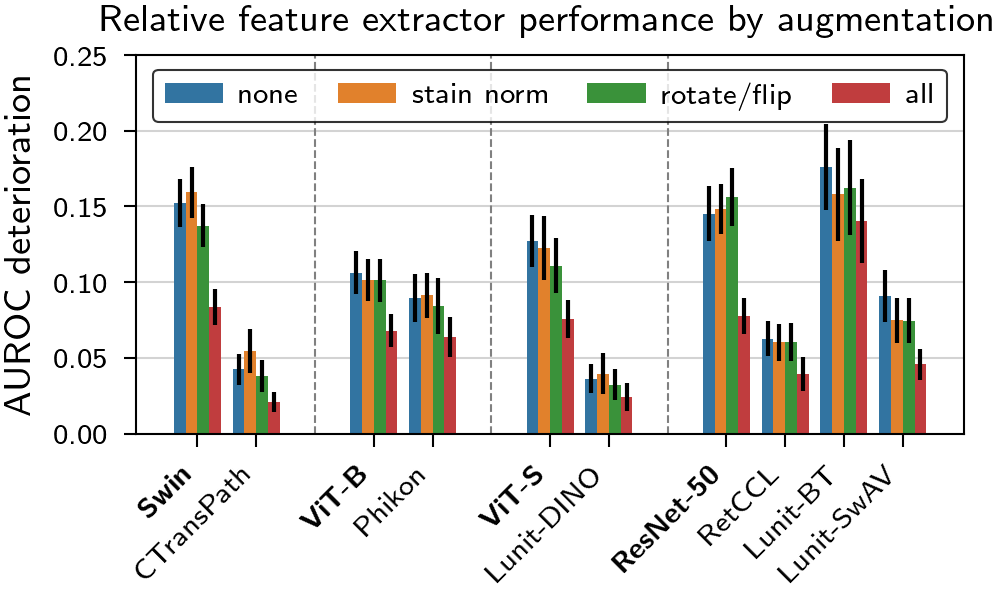

In [122]:
q = r["average"].query("model == 'AttentionMIL' and augmentations != 'Macenko_patchwise'").droplevel("model")
# q = compute_overall_average(d)["average"].query("model == 'AttentionMIL' and augmentations != 'Macenko_patchwise'").droplevel("model")

import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import axes, bundles, figsizes

from histaug.utils.display import RENAME_AUGMENTATION_GROUPS, FEATURE_EXTRACTOR_GROUPS

with plt.rc_context(
    {
        **axes.lines(),
        **bundles.tmlr2023(family="sans-serif"),
        **figsizes.cvpr2022_half(),
        "figure.dpi": 300,
    }
):
    RENAME_AUGMENTATION_GROUPS = {
        "none": "none",
        "Macenko_slidewise": "stain norm",
        "simple_rotate": "rotate/flip",
        "all": "all",
    }

    def format_feature_extractor(new_name: str):
        if new_name in FEATURE_EXTRACTOR_GROUPS:
            return f"\\textbf{{{new_name}}}"
        return new_name

    q["Augmentations"] = q.index.get_level_values("augmentations").map(RENAME_AUGMENTATION_GROUPS)
    q["Feature extractor"] = (
        q.index.get_level_values("feature_extractor").map(RENAME_FEATURE_EXTRACTORS).map(format_feature_extractor)
    )

    # bar plot
    p = sns.barplot(
        data=q.reset_index(),
        x="Feature extractor",
        y="mean",
        hue="Augmentations",
        hue_order=RENAME_AUGMENTATION_GROUPS.values(),
        order=[
            x
            for y in [
                [
                    *([" " * i] if i != 0 else []),
                    *[format_feature_extractor(RENAME_FEATURE_EXTRACTORS[extractor]) for extractor in extractors],
                ]
                for i, extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
            ]
            for x in y
        ],
    )

    i = 0
    xticks = []
    for group in FEATURE_EXTRACTOR_GROUPS.values():
        xticks.extend(range(i, i + len(group)))
        if i != 0:
            plt.axvline(x=i - 1, linestyle="--", color="grey", linewidth=0.5)
        i += len(group) + 1

    plt.xticks(xticks, rotation=45, ha="right")

    # error bars using "std" column
    for i, augmentation_group in enumerate(RENAME_AUGMENTATION_GROUPS):
        a = q.query(f"augmentations == '{augmentation_group}'").droplevel("augmentations")
        # order by feature extractor
        a = a.reindex(RENAME_FEATURE_EXTRACTORS.keys())
        plt.errorbar(
            x=np.array(xticks) + (i / len(RENAME_AUGMENTATION_GROUPS)) * 0.8 - 0.3,
            y=a["mean"],
            yerr=a["std"],
            fmt="none",
            c="black",
        )
        # break

    plt.xlabel("Feature extractor")
    plt.ylabel("AUROC deterioration")
    plt.xticks(rotation=45)
    plt.legend(
        title=None,
        loc="upper center",
        ncol=4,
        columnspacing=1.3,
        handletextpad=0.55,
    )
    plt.ylim(0, 0.25)

    # light grey grid
    plt.grid(axis="y", color="lightgrey")
    plt.xlabel("")
    plt.title("Relative feature extractor performance by augmentation")
    plt.show()